# Classification, clustering for detection of bad frames from High-contrast astronomical images

First, the good/bad frames separation from an image sequence is an unsupervised learning problem, as we don't have any labels or ground truth; it's not a classification per se where we'd need labeled data. Different options available:
- Algorithms based on some heuristics using the pixel statistics in an specific area of the frame. It's the current practice. This requires domain knowledge (prior know-how of the problem) + some visual inspection + stats plots + quality of resulting final image,
- Clustering algorithms (unsupervised learning). Training it to discover two clusters,
- Turning the problem into a supervised learning one. Labeling a subset of the data and train a classifier.

http://scikit-learn.org/stable/modules/clustering.html#clustering

In [150]:
%matplotlib inline
ds9 = vortex.display_array_ds9
import numpy as np
from matplotlib.pyplot import *
import seaborn
from IPython.html import widgets

rc("savefig", dpi=90)

seaborn.set_style('darkgrid') # also sets grey colors :(
seaborn.set_palette("deep") 
# jet()

http://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html#palette-tutorial

deep, muted, bright, pastel, dark, colorblind, hls, husl, any matplotlib palette

http://stanford.edu/~mwaskom/software/seaborn/tutorial/aesthetics.html

There are five preset seaborn themes: darkgrid, whitegrid, dark, white, and ticks

##### Loading the data. Cube lmircam bad/good frames

In [2]:
path = '/Users/cgg/Documents/VORTEX_loc/HR8799/2013-10-17_SCI_hr8799_DIT-494ms-3um_IMG.fits'
cubebig, _ = vortex.open_fits(path)


Fits HDU:0 data and header successfully loaded. Data shape: [15267,256,256]


In [3]:
cube = cubebig[3270: 3470] # 200 frames

"cube_sel" contains a subset of bad and good frames, and "labels" are manually (visual inspection) indicating whether the frame is good or bad.

In [4]:
cube_sel = np.vstack((cube[:30],cube[140:160],cube[190:200],cubebig[3840:3880]))
cube_sel = vortex.cube_crop_frames(cube_sel, 100)
cube_sel.shape

(100, 100, 100)

In [5]:
ds9(cube_sel) # adjust the cuts and a good color scheme (b)

In [7]:
labels = np.array([0,0,0,0,0,1,1,1,2,0,
                   0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,
                   0,2,2,2,2,2,2,2,1,1,
                   1,2,2,2,2,2,2,2,0,0,
                   0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,2,1,1,1,1,1,
                   1,1,1,1,1,1,1,2,0,0,
                   0,0,0,0,0,0,0,0,0,0])

In [8]:
labels2 = labels.copy()
labels2[labels2 == 2] = 0  # in labels2 I asume int quality are good

In [7]:
#ds9(cube_sel[np.where(labels==0)]) # good frames
print np.where(labels==0)[0]

[ 0  1  2  3  4  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 88 89 90 91 92 93 94 95 96 97 98 99]


In [8]:
#ds9(cube_sel[np.where(labels==1)]) # bad frames
print np.where(labels==1)[0]

[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]


In [9]:
#ds9(cube_sel[np.where(labels==2)]) # intermediate quality frames
print np.where(labels==2)[0]

[ 8 31 32 33 34 35 36 37 41 42 43 44 45 46 47 74 87]


Visually labeling is kind of hard due to the overlapping classes (bad/good). 

Examples of bad and good frames

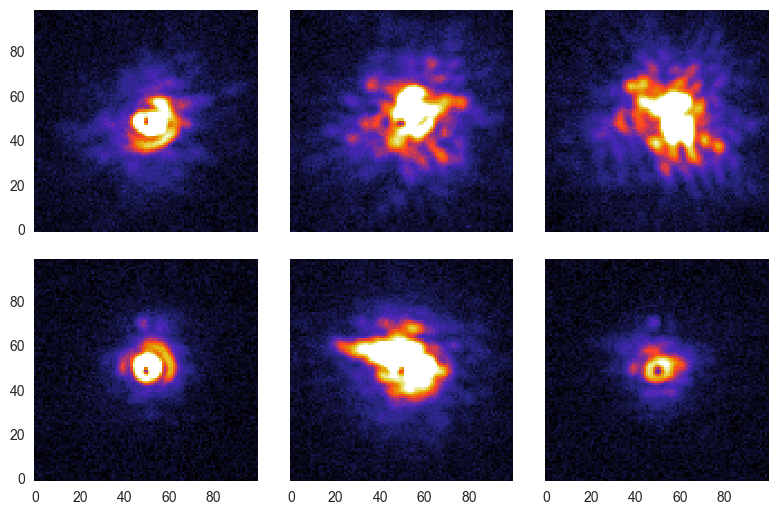

In [133]:
bfr_list = np.where(labels[:]==1)[0]
fig1, axes = subplots(2, len(bfr_list[:6])/2, figsize=(8,5.3), 
                      sharey=True, sharex=True)
fig1.tight_layout()
axes = axes.flatten()
for i, fr in enumerate(bfr_list[:6]):
    axes[i].imshow(cube_sel[fr], origin='lower', interpolation='nearest',
                   vmin=-10, vmax=400, cmap='CMRmap')
    axes[i].grid('off')

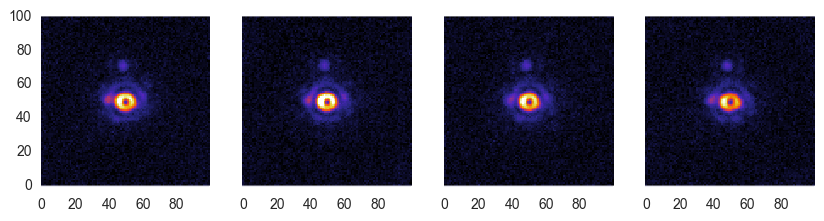

In [148]:
jet()
gfr_list = np.where(labels==0)[0][10:]
fig2, axes2 = subplots(1, len(gfr_list[:4]), figsize=(8.4,2.3), 
                      sharey=True, sharex=True)
fig2.tight_layout()
axes2 = axes2.flatten()
for i, fr in enumerate(gfr_list[:4]):
    axes2[i].imshow(cube_sel[fr], origin='lower', interpolation='nearest', 
                    vmin=-10, vmax=400, cmap='CMRmap')
    axes2[i].grid('off')

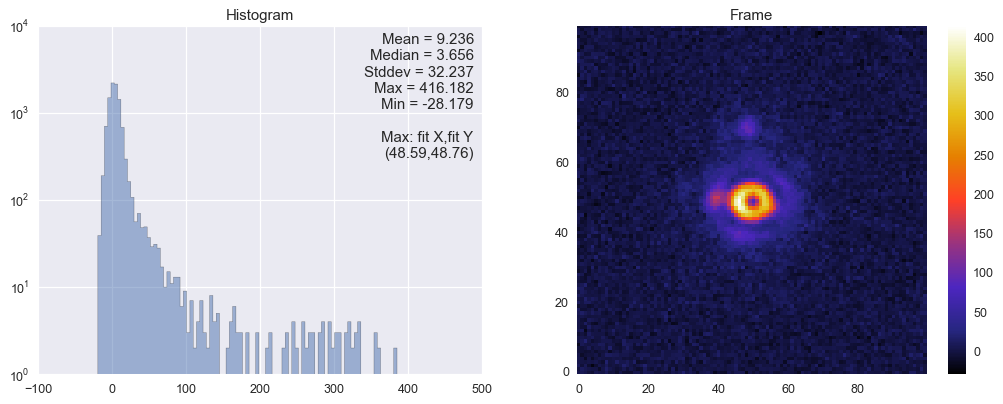

In [151]:
_ = vortex.frame_histo_stats(cube_sel[99])  # Good frame

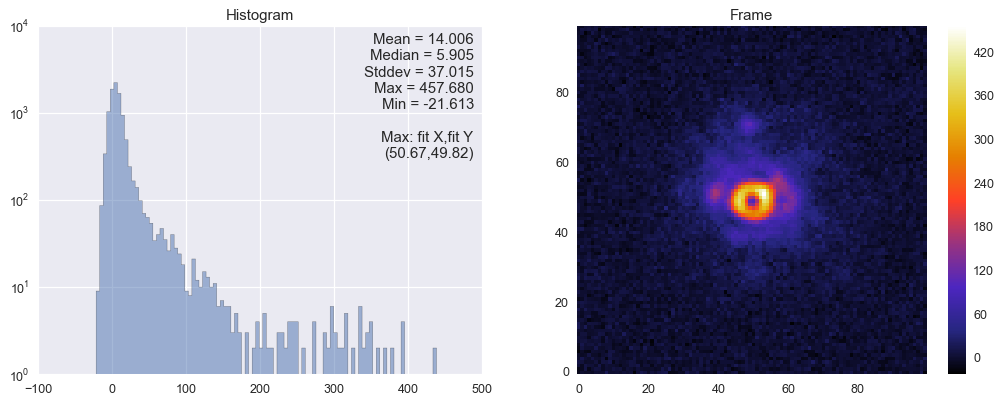

In [152]:
_ = vortex.frame_histo_stats(cube_sel[8]) # intermediate quality frame

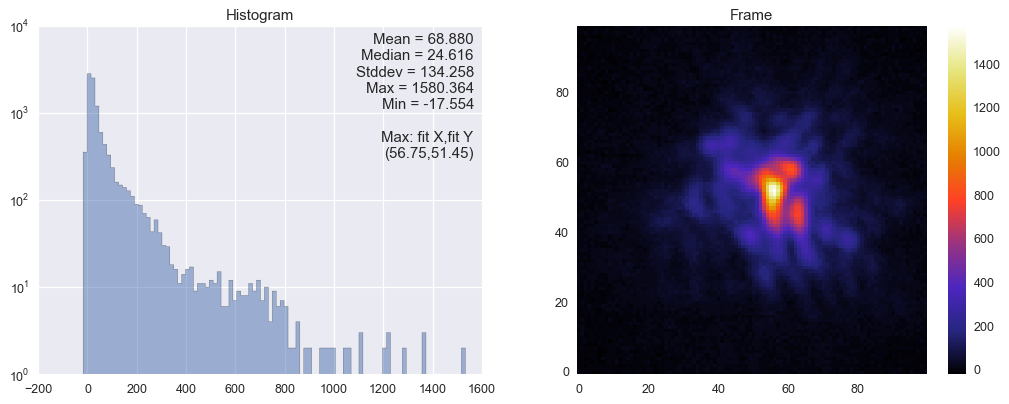

In [153]:
_ = vortex.frame_histo_stats(cube_sel[7]) # Bad frame

# Performance of custom made algorithms

Heuristic custom made algorithms in the vortex pipeline based on the annuluswise px statistics and frame correlation/distance wrt to a good reference frame.

### Pixels statistics in annulus

Annulus from 1.5 to 4 lambda/D (inner_radius=6, width=10)

In [1083]:
vortex.cube_remove_badfr_pxstats?

The algorithm works by taking the pixel statistics in an annulus (we set it to 1.5 to 4 lambda/D) and we do a sigma deviation thresholding. This way we capture the most bright frames in that annulus (bad frames - lot of leaked starlight).

upper sigma = 0.4
-------------------------------------------------------------------
Starting time: 2015-04-03 10:29:41
-------------------------------------------------------------------
Done calculating stats in annulus
Done removing bad frames from cube: 18 out of 100 (18.0%)
Running time:  0:00:00.092122
-------------------------------------------------------------------
[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]
[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]
18 bad frames
18 true bad frames found
0 false bad frames found


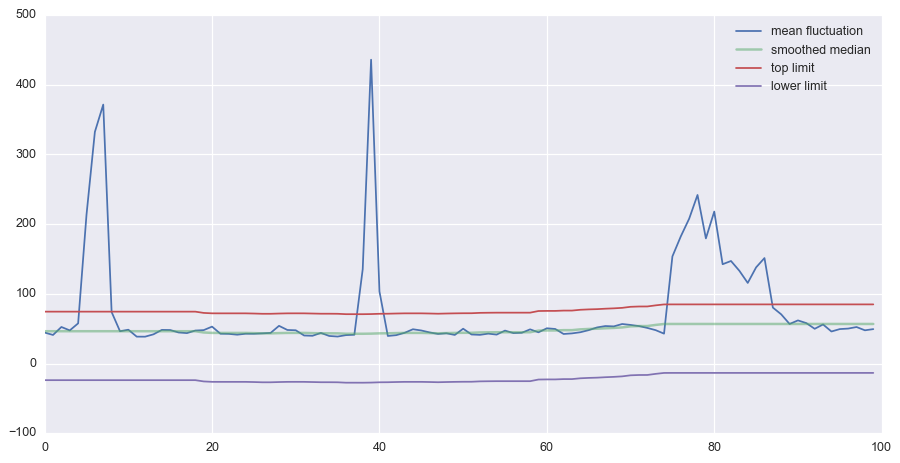

In [162]:
def slider_vpxst(upsig):
    func = vortex.cube_remove_badfr_pxstats
    
    print("upper sigma = {}".format(upsig))
    gind, bind = func(cube_sel, mode='annulus', in_radius=6, width=10,
                      top_sigma=upsig, low_sigma=1, plot=True)
    #print("bad frames : {}".format(bind))
    lab_bfr = np.where(labels==1)[0]
    print lab_bfr
    print bind
    common_ind = np.intersect1d(lab_bfr, bind)
    #print common_ind
    print '{:} bad frames'.format(len(lab_bfr))
    print '{:} true bad frames found'.format(len(common_ind))
    print '{:} false bad frames found'.format(len(bind)-len(common_ind))
    
widgets.interact(slider_vpxst, upsig=widgets.FloatSliderWidget(min=0.0, 
                                                               max=1.0, 
                                                               step=0.02, 
                                                               value=0.1))

- All bad frames can be found (if we know exactly the percentage of bad frames in out cube).
- When increasing the sigma the false detections rate grows.
- The sigma threshold should be picked by hand!!! How to know this a priori?
- The plot is interesting as it shows the temporal evolution of the mean in a region of importance. This mean is a key factor as we'll see later.

##### Big Array

We'll focuse on (15267, 100, 100) cropped cube.

In [164]:
X_big = vortex.cube_crop_frames(cubebig, 100)
X_big = vortex.prepare_matrix(X_big)
X_big.shape

Done creating and centering the matrix


(15267, 10000)

In [165]:
X_big.shape

(15267, 10000)

In [166]:
cube_X_big = vortex.reshape_matrix(X_big, 100, 100)

In [167]:
cube_X_big.shape

(15267, 100, 100)

-------------------------------------------------------------------
Starting time: 2015-04-03 11:06:44
-------------------------------------------------------------------
Done calculating stats in annulus
Done removing bad frames from cube: 465 out of 15267 (3.05%)
Running time:  0:00:33.348173
-------------------------------------------------------------------


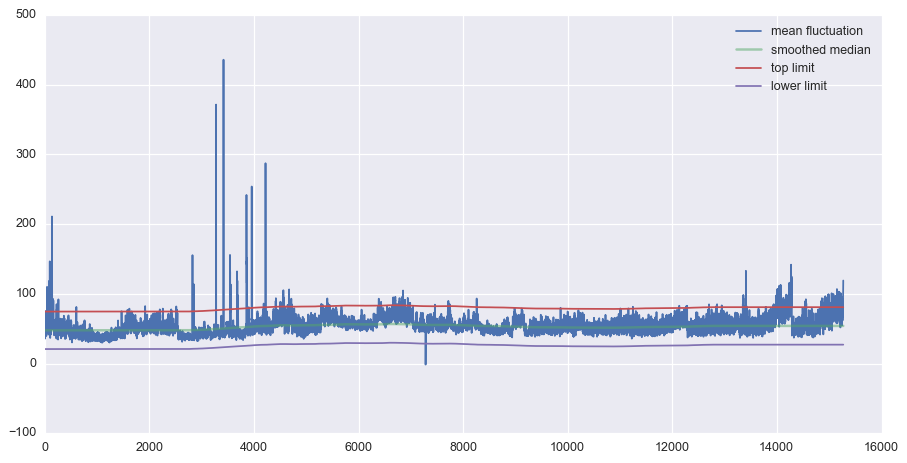

In [180]:
f1 = vortex.cube_remove_badfr_pxstats
res_pxst = f1(cubebig, mode='annulus',in_radius=6, width=10,top_sigma=2,low_sigma=2, plot=True)

In [ ]:
def gbfr2labels(gfr, bfr):
    array_out = np.empty((len(gfr)+len(bfr)))
    array_out[gfr] = 0
    array_out[bfr] = 1
    return array_out

In [178]:
def plot_compare_max_mean(pred_lab):
    res0 = vortex.cube_stats_annulus(cube_X_big[np.where(pred_lab==0)], 
                                     inner_radius=2, size=4, plot=False, 
                                     full_out=True, verbose=True)
    res1 = vortex.cube_stats_annulus(cube_X_big[np.where(pred_lab==1)], 
                                     inner_radius=2, size=4, plot=False, 
                                     full_out=True, verbose=True)
    figure(figsize=(12,4))
    plot(res0[-1], label='max donut in goodfr', alpha=0.5)
    plot(res1[-1], label='max donut in badfr', alpha=0.8)
    legend()

    res2 = vortex.cube_stats_annulus(cube_X_big[np.where(pred_lab==0)], 
                                     inner_radius=8, size=10, plot=False, 
                                     full_out=True, verbose=True)
    res3 = vortex.cube_stats_annulus(cube_X_big[np.where(pred_lab==1)], 
                                     inner_radius=8, size=10, plot=False, 
                                     full_out=True, verbose=True)
    
    figure(figsize=(12,4))
    plot(res2[0], label='mean outside donut in goodfr', alpha=0.5)
    plot(res3[0], label='mean outside donut in badfr', alpha=0.8)
    legend()

Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


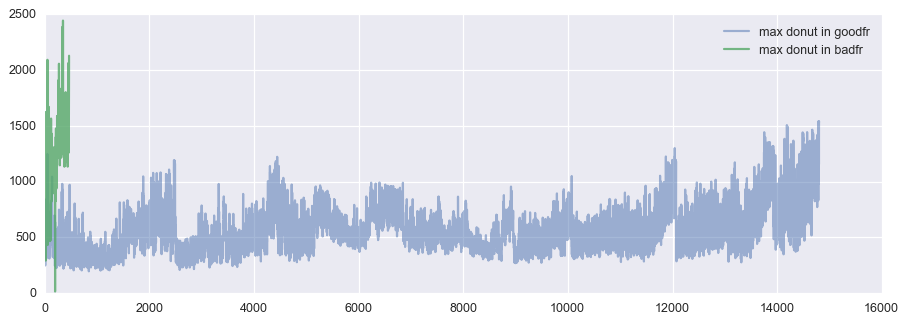

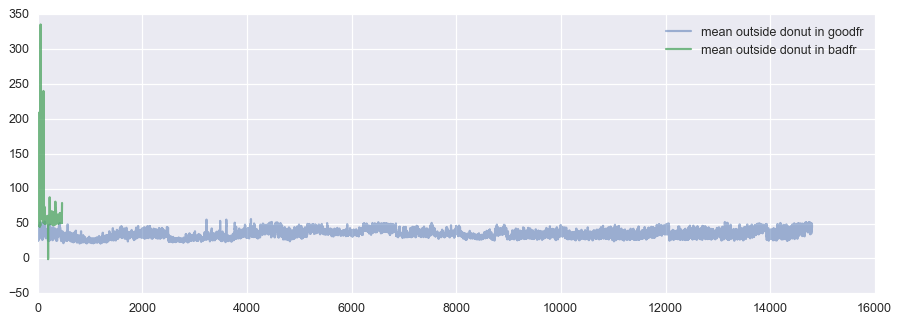

In [183]:
lab_pxst = gbfr2labels(res_pxst[0], res_pxst[1])
plot_compare_max_mean(lab_pxst)

- 1 min for big cube,
- Defectuous low brightness frame captured,
- Only 135 frames labeled as bad when upper sigma is 3,
- Looks good visually, but my criterion might differ from others (for instance Denis doesn't like the bright donuts even if they have good shape!),
- The mean behaviour is how we expect, low after discarding the outliers (obviosly since that was the criterion),
- Most bright frames in donut are captured as bad but many are in the good frames. This differs from the results above for clustering and classification.

In [212]:
ds9(cube_X_big[res_pxst[0]],cube_X_big[res_pxst[1]])

-------------------------------------------------------------------
Starting time: 2015-04-03 11:11:12
-------------------------------------------------------------------
Done calculating stats in annulus
Done removing bad frames from cube: 0 out of 14802 (0.0%)
Running time:  0:00:50.020242
-------------------------------------------------------------------


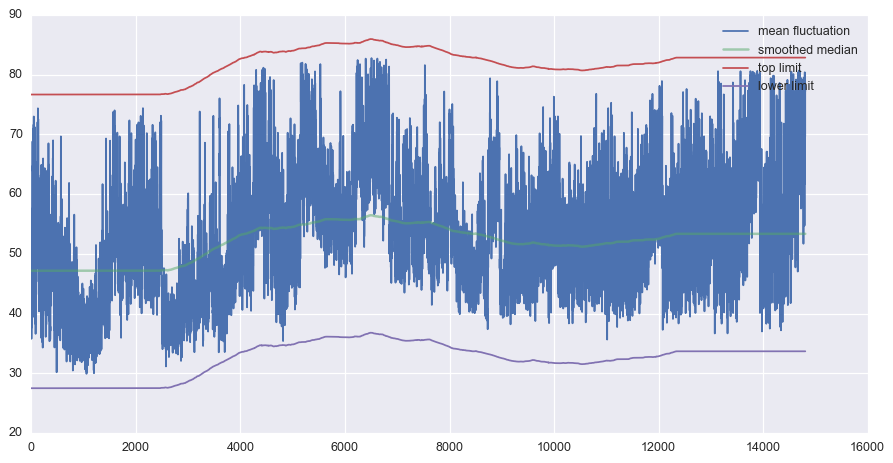

In [184]:
f1 = vortex.cube_remove_badfr_pxstats
res_pxst2 = f1(cubebig[res_pxst[0]], mode='annulus',in_radius=6, width=10,top_sigma=3,low_sigma=2, plot=True)

### Distance/correlation

In [171]:
vortex.cube_remove_badfr_correlation?

The algorithm works by selecting a frame reference (good frame) and measuring the distance to the rest of the frames (actually 30x30 central area is compared). 6 different distance/correlation metrics are available. Then the percentage of bad frames is suppossed to be guessed in advance. This can be seen as an advantage (tuneable and versatile, can grab eventually the intermediate quality frames). The the percentage is not known and one must iterate to manually pick it (choosing it too high we are sacrificing potentially good frames).

metric = euclidean
percentile = 18
-------------------------------------------------------------------
Starting time: 2015-04-03 11:26:18
-------------------------------------------------------------------
Done removing bad frames from cube: 18 out of 100 (18.0%)
Running time:  0:00:00.041354
-------------------------------------------------------------------
[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]
[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]
18 bad frames
18 true bad frames found
0 false bad frames found


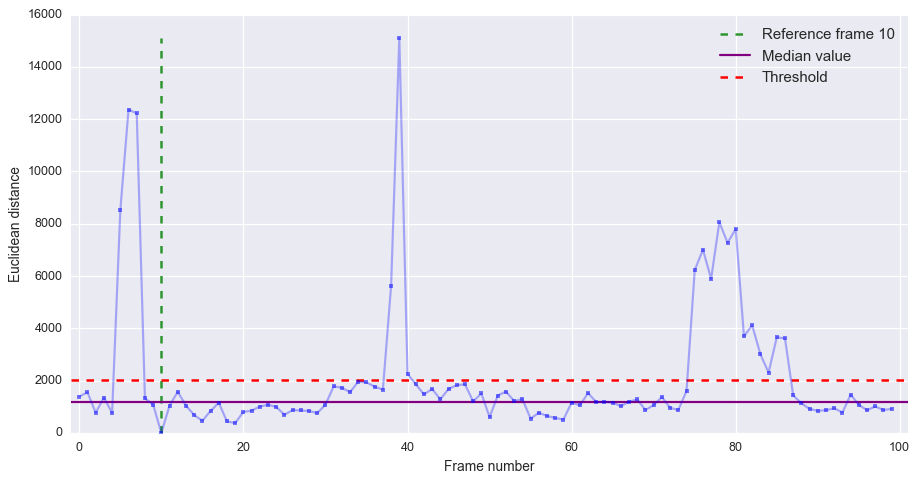

In [185]:
def slider_vcorrel(metric, percentile):
    func = vortex.cube_remove_badfr_correlation
    metric_list = ['sad', 'euclidean', 'mse', 'pearson', 'spearman', 'ssim']
    
    print("metric = {}".format(metric_list[metric]))
    print("percentile = {}".format(percentile))
    gind, bind = func(cube_sel, 10, dist=metric_list[metric],
                      percentile=percentile, plot=True)
    #print("bad frames : {}".format(bind))
    lab_bfr = np.where(labels==1)[0]
    print lab_bfr
    print bind
    common_ind = np.intersect1d(lab_bfr, bind)
    #print common_ind
    print '{:} bad frames'.format(len(lab_bfr))
    print '{:} true bad frames found'.format(len(common_ind))
    print '{:} false bad frames found'.format(len(bind)-len(common_ind))
    
widgets.interact(slider_vcorrel, metric=(0,5), percentile=(0,99))

- We can have 0 error prediction again asuming that we know the correct percentage of bad frames.
- The SAD, euclidean, mse, SSIM metrics find ALL the bad frames picked visually.
- Pearson and spearman correlations disagree in one frame.
- Increasing the percentage we start to capture the intermediate quality frames. 
- We see the percentage threshold could be adjusted with a sigma deviation criterion but again the threshold should be picked by hand.
- This plot is interesting as it shows how the distance between images goes with the previous plot (mean in annulus).
- The algorithm is sensible to the choice of the so called "reference" image. A bad reference image will screw the results. But, what is a good choice of a good frame for reference? they are not that homogeneous. Probably here an educated human decision will do well every time.

##### Big Array

In [215]:
#ds9(cube_X_big)
ds9(cube_X_big[7242]) #reference good frame

-------------------------------------------------------------------
Starting time: 2015-04-03 11:51:37
-------------------------------------------------------------------
Done removing bad frames from cube: 458 out of 15267 (3.0%)
Running time:  0:00:00.281418
-------------------------------------------------------------------


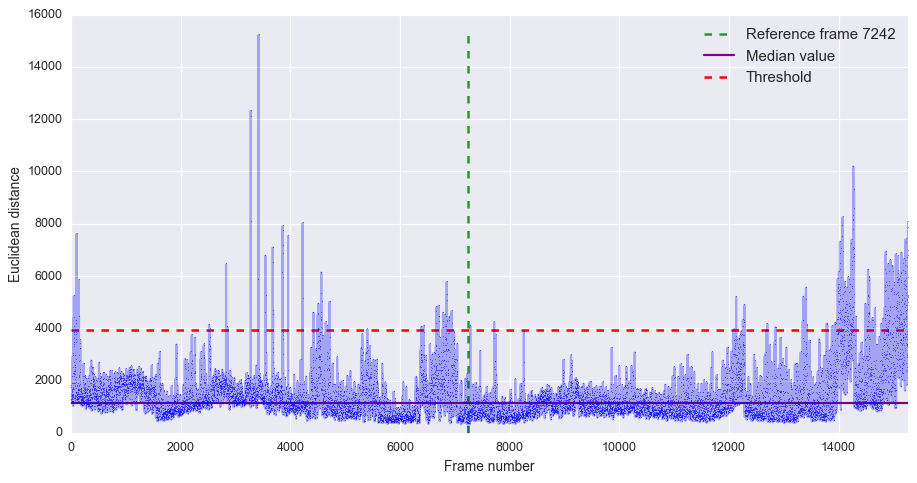

In [191]:
f2 = vortex.cube_remove_badfr_correlation
res_correl = f2(cube_X_big, 7242, 'euclidean', percentile=3, plot=True)

Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


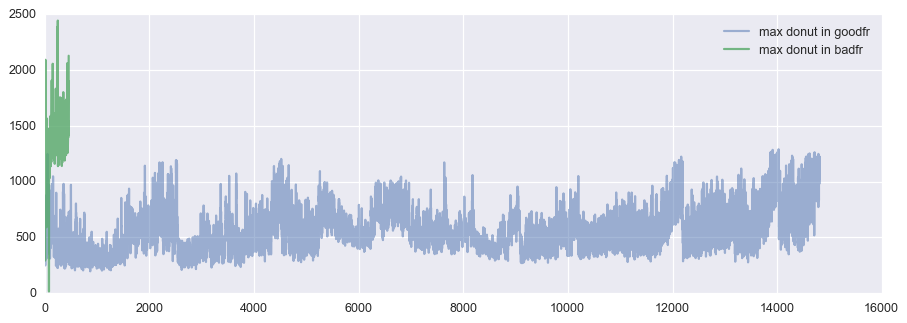

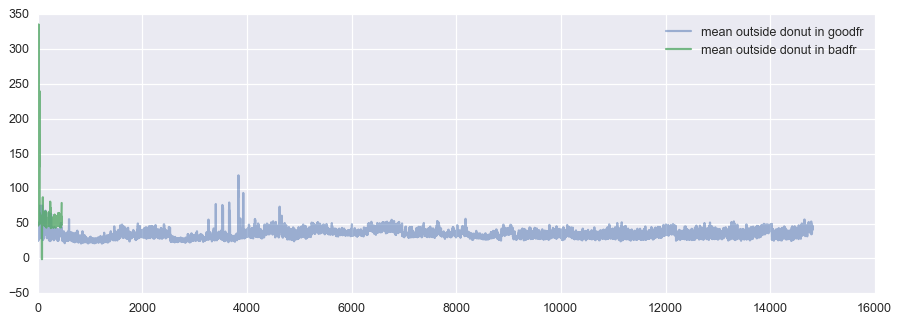

In [192]:
lab_correl = gbfr2labels(res_correl[0], res_correl[1])
plot_compare_max_mean(lab_correl)

- We assume there is 3% bad frames (from previous method low bound 1%),
- Defectuous low brighness frame captured,
- Goes super fast for big cubes if choosing simple distances like sad or euclidean: 
    - SAD: <1s
    - euclidean: <1s
    - mse: <1s
    - SSIM: 13s
    - pearson: 1.5s
- Euclidean, mse, pearson look worse at capturing the mean deviating frames around ~[3500:4000],
- SAD visual inspection looks alright.

In [248]:
ds9(cube_X_big[res_correl[0]],cube_X_big[res_correl[1]])

In [196]:
np.intersect1d(res_correl[1], res_pxst[1]).shape, res_correl[1].shape, res_pxst[1].shape

((324,), (458,), (465,))

In [199]:
32400./460

70.43478260869566

# Performance of Machine Learning Clustering algorithms

We create a matrix out of the selected frames (observations matrix).

In [200]:
X = vortex.prepare_matrix(cube_sel)

Done creating and centering the matrix


In [201]:
X.shape

(100, 10000)

### Hierarchical clustering (scipy)

Connectivity based clustering, also known as hierarchical clustering, is based on the core idea of objects being more related to nearby objects than to objects farther away. These algorithms connect "objects" to form "clusters" based on their distance. A cluster can be described largely by the maximum distance needed to connect parts of the cluster. At different distances, different clusters will form, which can be represented using a dendrogram, which explains where the common name "hierarchical clustering" comes from: these algorithms do not provide a single partitioning of the data set, but instead provide an extensive hierarchy of clusters that merge with each other at certain distances.

Scipy clustering package implements hieralhical clustering and kmeans algorithm.

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week3/svd_pca.ipynb
http://nbviewer.ipython.org/github/dataminingapp/dataminingapp-lectures/blob/master/Lecture-9/Other-Clustering-Algorithms.ipynb

In [202]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

What's the best match for distance measure and linkage (clustering method)?

In [199]:
pdist?

Pairwise distances between observations in n-dimensional space. The metrics are:
'braycurtis’, ‘canberra’, 'cityblock' (manhattan), 'correlation', 'cosine', ‘chebyshev’, ‘correlation’, ‘dice’, 'euclidean', ‘hamming’, 'jaccard’, 'kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, 'rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 'sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’ 

http://het.as.utexas.edu/HET/O_M/Operations/Scipy/generated/scipy.spatial.distance.pdist.html

In [24]:
linkage?

Performs hierarchical/agglomerative clustering on the condensed
distance matrix y. The hierarchical clustering method can be: 
- single (nearest point algorithm), 
- complete (farthest point or Voor Hees algorithm), 
- average (UPGMA), 
- median (WPGMC ), 
- weighted (WPGMA), 
- centroid (UPGMC),
- ward (incremental algorithm). 
It defines how the distance between clusters is calculated.
It accepts the observations matrix and computes the distances internally with pdist.

In [33]:
dendrogram?

Plots the hierarchical clustering as a dendrogram. The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton
cluster and its children.

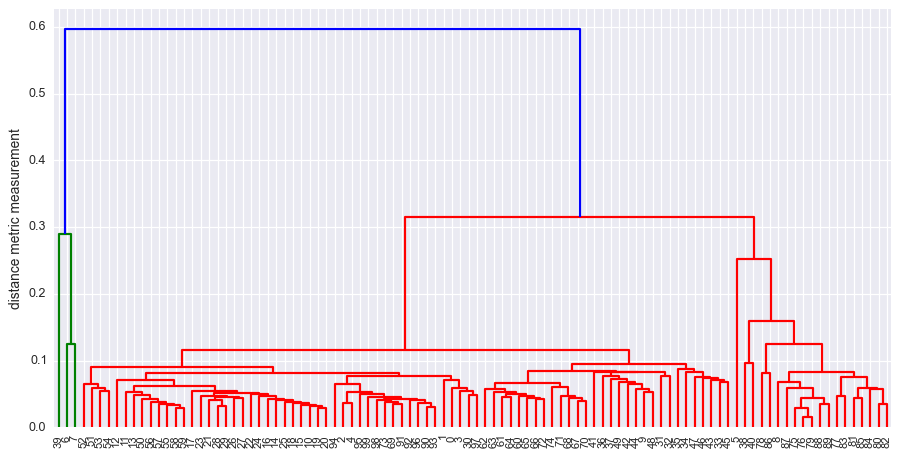

In [205]:
figure(1, figsize=(12, 6))
# distEuc = pdist(X,'euclidean') # condensed matrix of distances
# clust = linkage(distEuc, method='average') # clustering of the matrix of distances
clust = linkage(X, metric='correlation',method='complete')
hh1 = dendrogram(clust, leaf_font_size=9)
ylabel('distance metric measurement')

Turning the condensed dist matrix to square redundant form

In [620]:
distEuc = pdist(X,'euclidean')
distEuc.shape
distEucSq = squareform(distEuc) 
distEucSq.shape

(100, 100)

In [621]:
clust.shape

(99, 4)

Hierarchical clustering returns a 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

In [622]:
fcluster?

Forms flat clusters from the hierarchical clustering defined by
the linkage matrix ``Z``.

In [623]:
thr = 0.2 # threshold used to 'cut' the dendrogram
fcluster(clust, thr, 'distance')

array([3, 3, 3, 3, 3, 5, 1, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

Let's create a simple widget with the option of changing the distance metric and the clusterization method:

In [16]:
widgets.interact?

metric = braycurtis
method = complete


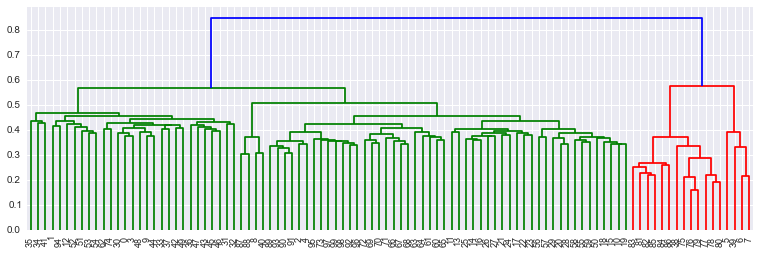

In [33]:
def slider_dmetric(metric, clusmet):
    met_list = ['braycurtis','canberra','cityblock','correlation','cosine',
                'chebyshev','correlation','euclidean','minkowski','seuclidean']
    method_list = ['single','complete','average','median','weighted',
                   'centroid','ward']
    
    print("metric = {}".format(met_list[metric]))
    print("method = {}".format(method_list[clusmet]))
    figure(1, figsize=(13, 4))
    clust = linkage(X, metric=met_list[metric], method=method_list[clusmet])
    hh1 = dendrogram(clust, leaf_font_size=9)
    show()
    
widgets.interact(slider_dmetric, metric=(0,9), clusmet=(0,6))

- Some combinations will throw an error, because some methods can me used ONLY with the euclidean distance.
- The performance of the metrics seems to be dependant of the data size, cosine metric and complete linkage worked very well when there were 60 frames, with 100 braycurtis does a better job.

http://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity
Bray-curtis dissimilarity (not really a distance measure) is used for integer valued spaces but can be used for real valued vectors.

In [34]:
np.where(labels==1)[0]

array([ 5,  6,  7, 38, 39, 40, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86])

##### Let's visualize the dendrograms and the distance matrices with seaborn

In [629]:
seaborn.clustermap?

Clustermap creates a dendrogram based on the data or the distance matrix. It's supossed to use under the hood the linkage function (so the methods are the same) but the cosine metric and complete linkage method gives slightly different result (4 instead of 7).

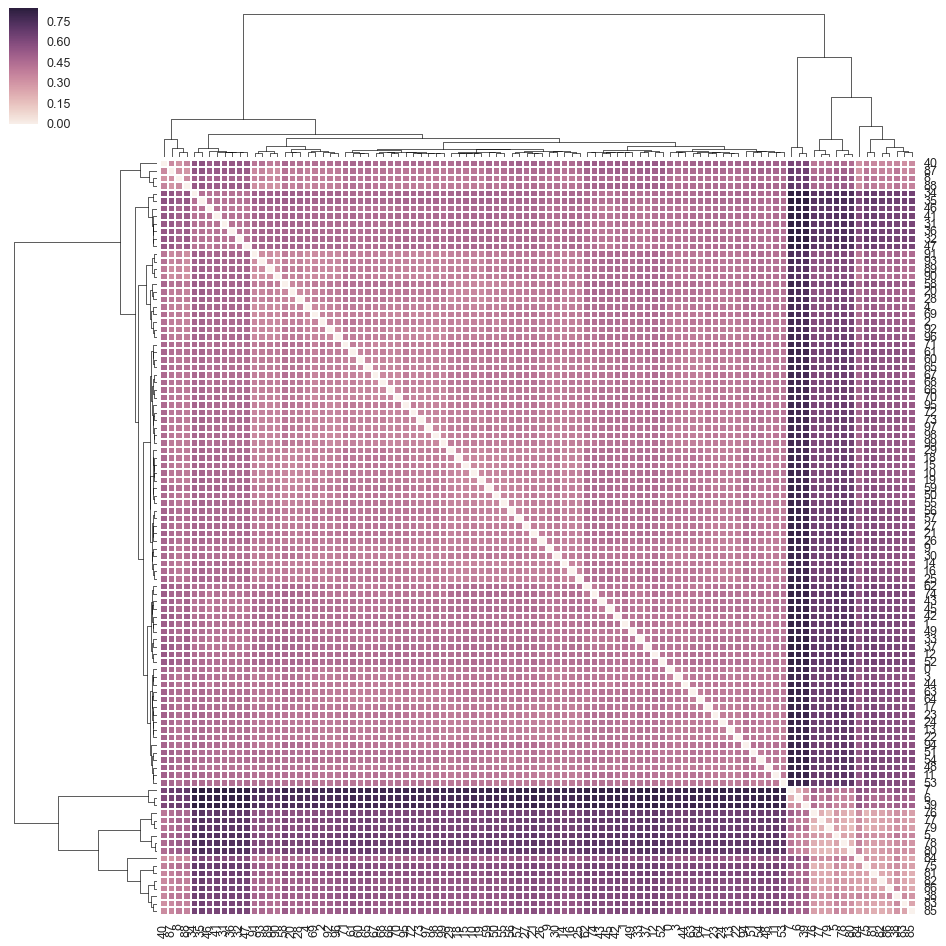

In [207]:
distCorr = pdist(X, 'braycurtis')
cm = seaborn.clustermap(squareform(distCorr), method="complete", 
                        figsize=(13,13))

Let's use sklearn pairwise_distances with the linkage function. Advantages: several ML common distances and the distance measures in pdist can be used as well, parallel implementation.
- Nothing different actually, same results as previously.

In [36]:
from sklearn.metrics import pairwise_distances

In [39]:
pairwise_distances?

Valid values for metric are:
From scikit-learn: ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']. These metrics support sparse matrix inputs. Notice: cityblock == manhattan == l1 and euclidean == l2

From scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 

See the documentation for scipy.spatial.distance for details on these metrics. These metrics do not support sparse matrix inputs.

Actually it ends-up complaining that the only metrics available are 'cosine', l1 and l2 :/

metric = l1
method = median


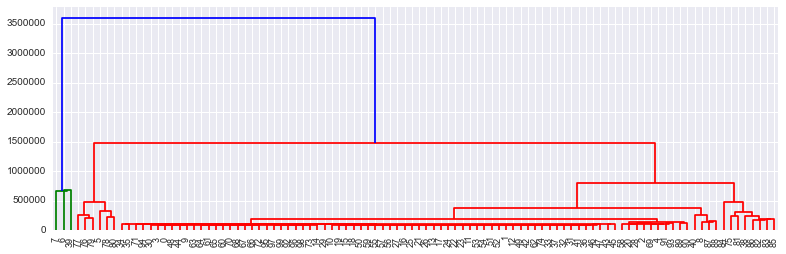

<function __main__.slider_dmetric>

In [38]:
def slider_dmetric(metric, clusmet):
    met_list = ['cosine', 'l1', 'l2']
    method_list = ['single','complete','average','median','weighted',
                   'centroid','ward']
    
    print("metric = {}".format(met_list[metric]))
    print("method = {}".format(method_list[clusmet]))
    figure(1, figsize=(13, 4))
    dist = pairwise_distances(X, metric=met_list[metric], n_jobs=2)
    clust = linkage(dist, method=method_list[clusmet])
    hh1 = dendrogram(clust, leaf_font_size=9)
    show()
    
widgets.interact(slider_dmetric, metric=(0,2), clusmet=(0,6))

##### Hierarchical clustering in scikit learn (agglomerative clustering) instead of the scipy's linkage

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.
The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:
- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

Linkage: Metric used to compute the linkage. Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or ‘precomputed’. If linkage is “ward”, only “euclidean” is accepted.

In [208]:
from sklearn.cluster import AgglomerativeClustering

In [209]:
from sklearn.metrics import adjusted_rand_score, classification_report

The Rand Index computes a similarity measure between two clusterings
by considering all pairs of samples and counting pairs that are
assigned in the same or different clusters in the predicted and
true clusterings.

In [665]:
AgglomerativeClustering?

In [210]:
def slider_aggclust(metric, method):
    metric_list = ['cosine', 'l1', 'l2']
    method_list = ['complete','average']
    print("metric = {}".format(metric_list[metric]))
    print("linkage = {}".format(method_list[method]))
    clust_agg = AgglomerativeClustering(n_clusters=2, 
                                        affinity=metric_list[metric], 
                                        linkage=method_list[method])
    lab_agg = clust_agg.fit_predict(X)
    cluster1 = np.where(lab_agg==0)[0]
    cluster2 = np.where(lab_agg==1)[0]
    if len(cluster1)<len(cluster2):
        bind = cluster1
    else:
        bind = cluster2
    #print("bad frames : {}".format(bind))
    lab_bfr = np.where(labels==1)[0]
    print lab_bfr
    print bind
    common_ind = np.intersect1d(lab_bfr, bind)
    #print common_ind
    print '{:} bad frames'.format(len(lab_bfr))
    print '{:} true bad frames found'.format(len(common_ind))
    print '{:} false bad frames found'.format(len(bind)-len(common_ind))
    print adjusted_rand_score(labels2, lab_agg)

widgets.interact(slider_aggclust, metric=(0,2), method=(0,1))

metric = l1
linkage = average
[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]
[ 6  7 39]
18 bad frames
3 true bad frames found
0 false bad frames found
0.199853491891


If linkage is “ward”, only “euclidean” is accepted.

In [211]:
clust_agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
lab_agg = clust_agg.fit_predict(X)
print np.intersect1d(np.where(lab_agg==0)[0],np.where(labels==1)[0])

[ 5  6  7 38 39 40 75 76 77 78 79 80 81 82 83 84 85 86]


In [212]:
adjusted_rand_score(labels2, lab_agg)

1.0

Euclidean metric and the ward linkage finds all the bad frames.

- Again the metric/clustering_method is suceptible to the data size. That will make this approach not perfect, as the two parameters will need to be tuned.
- Euclidean_metric/ward_clustering works really well. The ward clustering method seems to be the key.
- The ward clustering method is not available in the scipy linkage function.
- Complete method doesn't perform good here.

Pros: 
  - We don't have here the dendrogram (and all the beautiful plots) but we can (have to) indicate the number of clusters and we get the predicted labels right away.
  - We know the number of clusters is 2 (bad or good frames) and can detect the bad frames given that we choose the correct metric and linkage method. 
  
Cons:
  - Not scalable, when used in the whole cube (15267 frames) takes too much (36 min). This is obvious since the clustering is done on the actual data, so the pairwise distance measures are computed for a large number of frames.
  - One disadvantage is that this is not a tunable algorithm (we can't choose to detect more or less bad frames).
  - It ends-up being very agressive, 2284 frames in the cluster of the bad ones but still some bad frames in the good cluster. In the bad frames cluster the frames have 

##### Agglomerative clustering on the whole cube

Let's work on a 100x100 cropped full cube (15267 frames).

In [209]:
print X_big.shape
print cube_X_big.shape

(15267, 10000)
(15267, 100, 100)


In [47]:
clust_agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                    linkage='ward')
%time lab_agg = clust_agg.fit_predict(X_big)

CPU times: user 34min 40s, sys: 18.3 s, total: 34min 59s
Wall time: 36min 1s


In [55]:
print (lab_agg==1).sum()

2284


In [215]:
228400/15267.

14.96037204427851

In [90]:
ds9(cube_X_big[np.where(lab_agg==0)], cube_X_big[np.where(lab_agg==1)])

Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


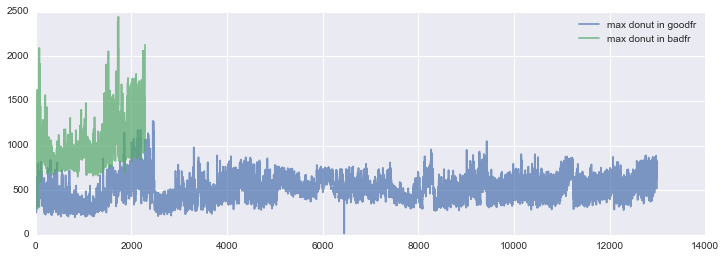

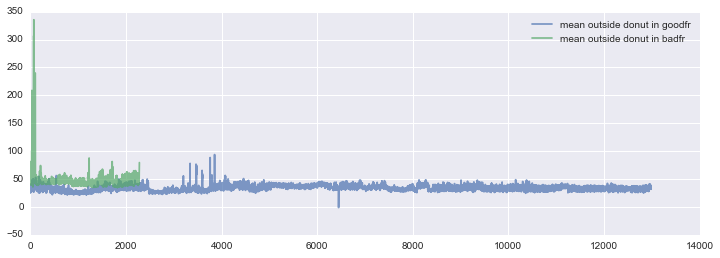

In [87]:
plot_compare_max_mean(lab_agg)

This confirms the visual inspection. There are two clusters: one with the bad frames and a lot of maybe good frames (good shape of the donut but higher pixels values), and one with the good frames (less bright donuts and mean outside smaller) and some really bad frames (distorted shape).

In [91]:
ds9(cube_X_big[np.where(lab_agg==0)][1647],cube_X_big[np.where(lab_agg==1)][1647])

In [92]:
clust_agg2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                    linkage='complete')
%time lab_agg2 = clust_agg.fit_predict(X_big)

CPU times: user 33min 3s, sys: 11 s, total: 33min 14s
Wall time: 33min 30s


In [95]:
np.array_equal(lab_agg,lab_agg2)

True

Ok, no change with the complete linkage instead or the ward clustering. Again data size dependant.

##### Using an annulus to compare the frames instead of the full frame

Annulus from 1.5 to 4 lambda/D 

In [52]:
ds9(cube_sel)

In [53]:
X_ann = vortex.get_annulus_cube?

In [157]:
np.where(labels2==0)

(array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
        74, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

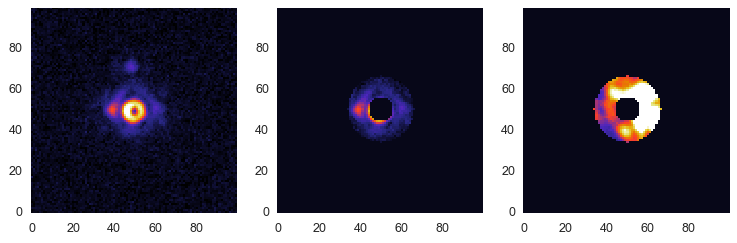

In [161]:
def plot_annulus(goodfr, badfr):
    fig2, (ax1,ax2,ax3) = subplots(1, 3, figsize=(10,5))
    ax1.imshow(goodfr, origin='lower', interpolation='nearest', cmap='CMRmap', vmin=-10, vmax=400)
    ax2.imshow(vortex.get_annulus(goodfr, 6, 10),
               origin='lower', interpolation='nearest', cmap='CMRmap', vmin=-10, vmax=400)
    ax3.imshow(vortex.get_annulus(badfr, 6, 10),
               origin='lower', interpolation='nearest', cmap='CMRmap', vmin=-10, vmax=400)
    ax1.grid('off')
    ax2.grid('off')
    ax3.grid('off')
    
plot_annulus(cube_sel[50], cube_sel[7])

In [98]:
X_ann = vortex.get_annulus_cube(cube_sel, fwhm, fwhm*3, output_values=True)

In [106]:
clust_agg3 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                    linkage='ward')
lab_agg3 = clust_agg3.fit_predict(X_ann)
cluster1 = np.where(lab_agg3==0)[0]
cluster2 = np.where(lab_agg3==1)[0]
if len(cluster1)<len(cluster2):
    bind = cluster1
else:
    bind = cluster2
det = np.intersect1d(bind, np.where(labels2==1)[0])
print det
print len(det), 'out of', len(np.where(labels2==1)[0])

[ 5  6  7 38 39 75 76 77 78 79 80 81 82 83 84 85 86]
17 out of 18


In [102]:
adjusted_rand_score(labels2, lab_agg3)

0.951601806865877

We find only all minus one bad frames using the pxs in an annulus.

In [104]:
from sklearn.preprocessing import StandardScaler

In [107]:
X_ann_st = StandardScaler().fit(X_ann).transform(X_ann)
lab_agg4 = clust_agg3.fit_predict(X_ann_st)
cluster1 = np.where(lab_agg4==0)[0]
cluster2 = np.where(lab_agg4==1)[0]
if len(cluster1)<len(cluster2):
    bind = cluster1
else:
    bind = cluster2
det = np.intersect1d(bind, np.where(labels2==1)[0])
print det
print len(det), 'out of', len(np.where(labels2==1)[0])

[ 5  6  7 38 39 75 76 77 78 79 80 81 82 83 84 85 86]
17 out of 18


Same thing when standard scaling. Still better to use the whole frames?

##### Big array (15k frames) in annuli

In [217]:
fwhm = 4
X_ann_big = vortex.get_annulus_cube(cubebig, fwhm, fwhm*3, output_values=True)
X_ann_big.shape

(15267, 752)

In [109]:
clust_agg5 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', 
                                    linkage='ward')
%time lab_agg5 = clust_agg5.fit_predict(X_ann_big)

CPU times: user 14min 30s, sys: 5.49 s, total: 14min 35s
Wall time: 14min 43s


In [112]:
(lab_agg5==1).sum()

2873

Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


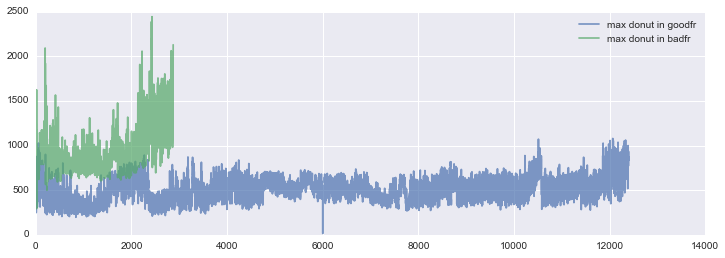

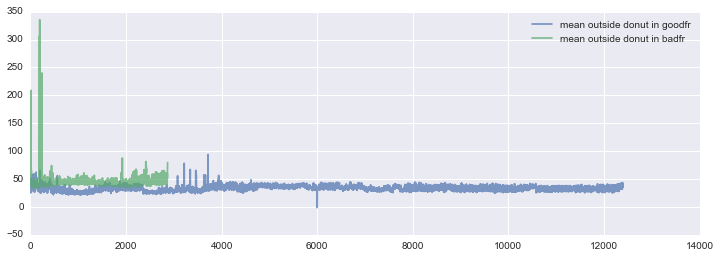

In [110]:
plot_compare_max_mean(lab_agg5)

Very similar though the cluster with bad frames is bigger. Looks like it has more of the good ones. The time was reduced in half (14 min).

### K-means clustering

Given a set of observations (x1, x2, …, xn), where each observation is a d-dimensional real vector, k-means clustering aims to partition the n observations into k (≤ n) sets S = {S1, S2, …, Sk} so as to minimize the within-cluster sum of squares (WCSS). In other words, its objective is to find:

$$\underset{\mathbf{S}} {\operatorname{arg\,min}} \sum_{i=1}^{k}  \sum_{\mathbf x \in S_i} \left\| \mathbf x  -  \boldsymbol\mu_i \right\|^2$$

where $μi$ is the mean of points in $Si$.

http://nbviewer.ipython.org/github/dataminingapp/dataminingapp-lectures/blob/master/Lecture-6/Clustering.ipynb

The k-means problem is solved using Lloyd’s algorithm. The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. 

The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from X, although they live in the same space. The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum of squared criterion:
$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_j - \mu_i||^2)$$

In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose k samples from the dataset X. After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.


In [219]:
from sklearn.cluster import KMeans

In [220]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10, 
                max_iter=100, tol=1e-4)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
error = kmeans.inertia_
#print "The total error of the clustering is: ", error
cluster1 = np.where(kmeans.labels_==0)[0]
cluster2 = np.where(kmeans.labels_==1)[0]
if len(cluster1)<len(cluster2):
    kmeans_bfr = cluster1
else:
    kmeans_bfr = cluster2
#print "Bad frames class", kmeans_bfr
det = np.intersect1d(kmeans_bfr, np.where(labels==1)[0])
print det
print len(det), 'out of', len(np.where(labels==1)[0])

[ 5  6  7 38 39 75 76 77 78 79 80 81 82]
13 out of 18


Most of the bad frames are found. The result is not deterministic (13 or 14 on different runs). Depends very much on cluster initialization.
Many papers on kmeans advanced clustering for outlier detection. Not the same as the original kmeans.

In [221]:
adjusted_rand_score(labels2, kmeans.labels_)

0.754206017224866

##### On big data

The k-means algorithm suffers from what is called the Curse of Dimensionality, the results are not that reliable for high dimensional data. This is an open area of research.

In [121]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10, 
                max_iter=100, tol=1e-4)
%time kmeans.fit_predict(X_big)
centroids = kmeans.cluster_centers_
#error = kmeans.inertia_
#print "The total error of the clustering is: ", error
kmeans_biglab = kmeans.labels_

CPU times: user 3min, sys: 2.88 s, total: 3min 3s
Wall time: 2min 17s


In [126]:
(kmeans_biglab==0).sum()

3787

In [127]:
def flip_0_1(array):
    array_out = np.empty_like(array)
    array_out[np.where(array==0)] = 1
    array_out[np.where(array==1)] = 0
    return array_out

Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


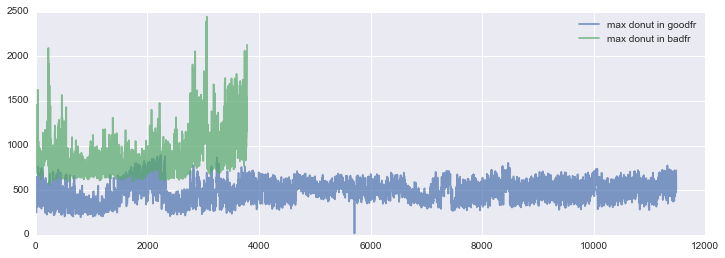

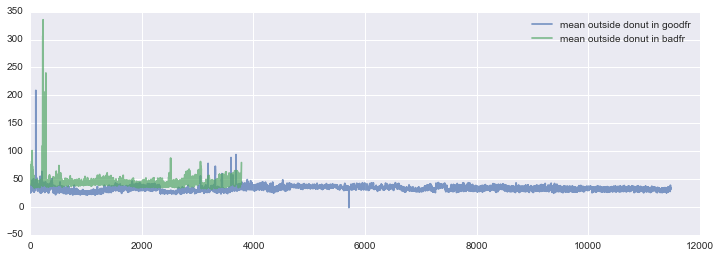

In [128]:
plot_compare_max_mean(flip_0_1(kmeans_biglab))

It has a similar result. I give up on clustering and move to the classification perspective.

# Classification

Supervised classification takes a set of features and relates them to predefined sets of classes. We start by assuming that we have a set of predetermined labels that have been assigned to a subset of the data we are considering. Our goal is to characterize the relation between the features in the data and their classes and apply these classifications to a larger set of unlabeled data.

### K nearest neighbors

The most widely used and powerful classifiers, the nearest-neighbor classifier: that is, just use the class label of the nearest point. The intuitive justification is that $p(y|x) ≈ p(y|x′)$ if $x′$ is very close to $x$.
The resulting decision boundary between the nearest-neighbor points is a Voronoi tessellation of the attribute space.
A smoothing parameter, the number of neighbors K , is typically used to regulate the complexity of the classification by acting as a smoothing of the data. In its simplest form a majority rule classification is adopted, where each of the K points votes on the classification. Increasing K decreases the variance in the classification but at the expense of an increase in the bias. Choosing K such that it minimizes the classification error rate can be achieved using cross-validation

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

The basic nearest neighbors classification uses uniform weights: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the weights keyword. The default value, weights = 'uniform', assigns uniform weights to each neighbor. weights = 'distance' assigns weights proportional to the inverse of the distance from the query point. 

http://scikit-learn.org/stable/modules/neighbors.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [225]:
from sklearn.neighbors import KNeighborsClassifier

An important methodological mistake: we are using all the instances available to train the model, and using the same instances to evaluate the model in terms of accuracy. It tell us (almost) nothing about the actual performance in production of the model, just how well it can reproduce the data it's been exposed too.
A way to work around that is to train the model over a subset of the available instances (the training set), calculate the train score, and test the model (i.e. calculate the test score) over the remaining of the instances (the test set).

Cross-validation consists into repeating this operation several times using successive splits of the original dataset into training and test sets, and calculating a summary statistic of the train and test scores over the iterations (usually average).

Several splits can be used:

- Random split: a given percentage of the data is selected at random (with replacement)
- K-folds: the dataset is divided into K exhaustive splits, each split is used as the test set, while the K-1 splits are using as the training set
- Stratified K-folds: for classification mainly. The folds are constructed so that the class distribution is approximately the same in each fold (e.g. the relative frequency of each class is preserved)
- Leave One Out: like K-fold with K = 1. One instance is left out, the model is built on the N-1 remaining instances, this procedure is repeated until all the instances have been used.

Static spliting (50/50)

In [718]:
X_train = X[:30]
y_train = labels2[:30]
X_test = X[30:]
y_test = labels2[30:]

Random spliting (66/33)

In [222]:
from sklearn.cross_validation import (train_test_split, cross_val_score, 
                                      ShuffleSplit, KFold)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, labels2, test_size=0.33, 
                                                    random_state=None)

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

The Nearest Neighbors Algorithm (brute, ball tree or kd tree) depends on the dataset. The brute one computes all the pairwise distances, which can be expensive (as in clustering). The trees algorithms are plugged in to aliviate theis constructing tree structures that suppress the need of all the pairwise distances.

http://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm

In [226]:
kneighb = KNeighborsClassifier(n_neighbors=3,weights='distance',algorithm='brute', 
                               leaf_size=10, p=2, metric='minkowski')
kneighb.fit(X_train, y_train)
kneighb_pred = kneighb.predict(X_test)
print kneighb_pred
print y_test
print "score", kneighb.score(X_test, y_test)

[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
score 1.0


- The result is deterministic.
- Setting the weights to 'distance' meaning that closer points have much influence in the voting improved in the case of 60 frames. when 100% it seems irrelevant. It might be different on the big real cube.
- Choosing carefully the number of neighbors (probably depends on the data size) is important. 
- KNN is very dependant on the distance metric. For the 100fr training data the metric is not that critical, euclidean seems to work fine, sometimes gives 100% score.
- We get in average score=95% in the classification. We must do cross-validation.
- Isuue: we have to label the frames for training data. It's important the number of train data, what's the optimal size? 

##### Completeness (sensitivity, recall) and contamination (type I error) 

In some fields the completeness and contamination are respectively referred to as the “sensitivity” and the “Type I error.” In astronomy, one minus the contamination is often referred to as the “efficiency.” In machine learning communities, the efficiency and completeness are respectively referred to as the “precision” and “recall.”

The completeness measures the fraction of total detections identified by our classifier, while the contamination measures the fraction of detected objects which are mis- classified.

In [228]:
from astroML.utils import completeness_contamination

completeness_contamination(kneighb_pred, y_test) 

(array(1.0), array(0.0))

##### Cross validation

The good score could be luck (we only used one train / test split here): Now we're going to use cross validation to repeat the train / test split several times to as to get a more accurate estimate of the real test score by averaging the values found of the individual runs

http://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

There's a wrapper for estimating cross validated scores directly, you just have to pass the instanciated cross validation method.

If the data ordering is not arbitrary (e.g. samples with the same label are contiguous), shuffling it first may be essential to get a meaningful cross- validation result. However, the opposite may be true if the samples are not independently and identically distributed. For example, if samples correspond to news articles, and are ordered by their time of publication, then shuffling the data will likely lead to a model that is overfit and an inflated validation score: it will be tested on samples that are artificially similar (close in time) to training samples.

http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [327]:
KFold?

In [231]:
cv = KFold(len(X), n_folds=3)

cc_scores = cross_val_score(kneighb, X, labels2, cv=cv, scoring='accuracy')
print cc_scores
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores.mean(), 
                                               cc_scores.std()*2)

[ 1.          0.96969697  0.87878788]
Accuracy: 0.95 (+/- 0.10)


##### ROC

http://scikit-learn.org/stable/auto_examples/plot_roc_crossval.html

Example of Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality using cross-validation.

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

This example shows the ROC response of different datasets, created from K-fold cross-validation. Taking all of these curves, it is possible to calculate the mean area under curve, and see the variance of the curve when the training set is split into different subsets. This roughly shows how the classifier output is affected by changes in the training data, and how different the splits generated by K-fold cross-validation are from one another.

When sources are rare, it is often more informative to plot the efficiency (equal to one minus the contamination) vs. the completeness. This can give a better idea of how well a classifier is recovering rare data from the background. !!!!!

In [232]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.cross_validation import StratifiedKFold

# Classification and ROC analysis

def plot_roc_curve(classifier, X, y):
    # Run classifier with stratified K Fold cross-validation (the folds are made 
    # by preserving the percentage of samples for each class) and plot ROC curves
    cv = StratifiedKFold(y, n_folds=3)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    figure(figsize=(8,8))
    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    xlim([-0.05, 1.05])
    ylim([-0.05, 1.05])
    xlabel('False Positive Rate')
    ylabel('True Positive Rate')
    title('Receiver operating characteristic example')
    legend(loc="lower right")

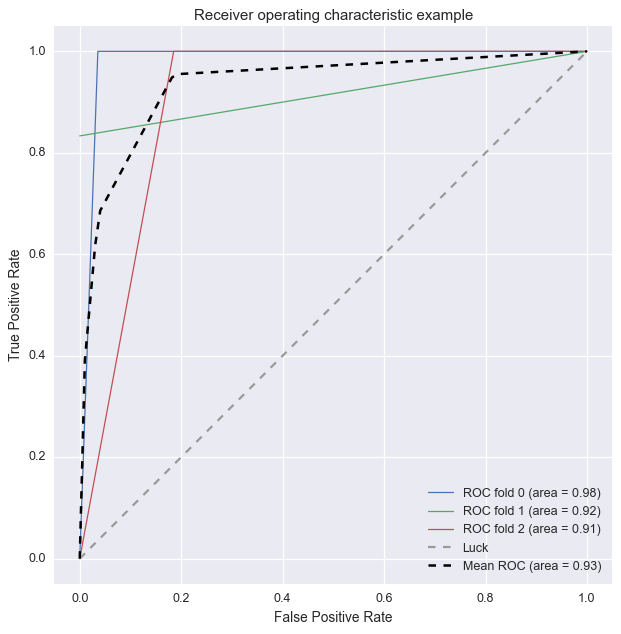

In [233]:
plot_roc_curve(KNeighborsClassifier(n_neighbors=1,weights='uniform',
                                    algorithm='brute', metric='cosine'), 
                                    X, labels2)

##### Confusion matrix

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [234]:
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(cm, class_names):
    labels = list(class_names)

    fig = figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    cax = ax.matshow(cm)
    title('Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    xlabel('Predicted Class')
    ylabel('True Class')
    grid('off')

    for i,j in ((x,y) for x in xrange(2) for y in xrange(2)):
        ax.annotate(str(cm[j][i]), xy=(i,j), color='white')


[[28  0]
 [ 0  5]]


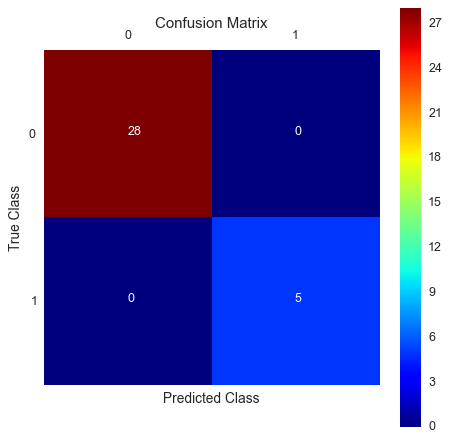

In [235]:
cm = confusion_matrix(y_test, kneighb_pred)
print cm
draw_confusion_matrix(cm, [0,1] )

### Decision tree classifier

http://scikit-learn.org/stable/modules/tree.html#tree-classification

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

As other classifiers, DecisionTreeClassifier take as input two arrays: an array X of size [n_samples, n_features] holding the training samples, and an array Y of integer values, size [n_samples], holding the class labels for the training samples.

In [236]:
from sklearn.tree import DecisionTreeClassifier

In [240]:
dectree = DecisionTreeClassifier(criterion='gini', splitter='best', 
                                 max_depth=2, min_samples_split=2, 
                                 min_samples_leaf=1, max_features=None, 
                                 random_state=None)
dectree.fit(X_train, y_train)
dectree_pred = dectree.predict(X_test)
print dectree_pred
print y_test
print dectree.score(X_test, y_test)

[0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
0.939393939394


In [242]:
completeness_contamination(dectree_pred, y_test) 

(array(0.8), array(0.2))

In [251]:
cc_scores3 = cross_val_score(dectree, X, labels2, cv=cv)
print cc_scores3
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores3.mean(), cc_scores3.std() * 2)

[ 0.97058824  0.96969697  1.        ]
Accuracy: 0.98 (+/- 0.03)


- Result is not deterministic, depends on the run, unless we give a seed. We don't know a priori which seed will give a best result for our run so better leave it random.
- The defaulsta parameters seem to work fine.

### Random Forest classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [252]:
from sklearn.ensemble import RandomForestClassifier

In [272]:
rndforest = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                   max_depth=3, min_samples_split=2, 
                                   min_samples_leaf=1, max_features='auto', 
                                   max_leaf_nodes=None, bootstrap=True, 
                                   oob_score=False, n_jobs=1, random_state=None)
rndforest.fit(X, labels2)
rndfor_pred = rndforest.predict(X)
print rndfor_pred
print labels2
print rndforest.score(X, labels2)

[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
1.0


- Random trees are ensemble methods that internally do cross-validation using a certain number of trees. 
- Accuracy around 95% in average.

In [284]:
completeness_contamination(rndfor_pred, y_test) 

(array(1.0), array(0.0))

### Gaussian Naive Bayes

http://es.wikipedia.org/wiki/Clasificador_bayesiano_ingenuo

No parameters! Seems like 'black magic'.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. Given a class variable y and a dependent feature vector x_1 through x_n, Bayes’ theorem states the following relationship:
$$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots x_n \mid y)}
                                 {P(x_1, \dots, x_n)}$$
Using the naive independence assumption that
$$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y),$$
for all i, this relationship is simplified to
$$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
                                 {P(x_1, \dots, x_n)}$$
Since $P(x_1, \dots, x_n)$ is constant given the input, we can use the following classification rule:
$$P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)$$

$$\Downarrow$$

$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),$$
and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$ and $P(x_i \mid y)$; the former is then the relative frequency of class y in the training set.

GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian:
$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$
The parameters \sigma_y and \mu_y are estimated using maximum likelihood.

http://scikit-learn.org/stable/modules/naive_bayes.html

In [267]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_pred = gnb.fit(X_train, y_train).predict(X_test)
print y_test
print gnb_pred
print gnb.score(X_test, y_test)

[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
1.0


In [268]:
completeness_contamination(gnb_pred, y_test) 

(array(1.0), array(0.0))

In [270]:
cc_scores4 = cross_val_score(gnb, X, labels2, cv=cv)
print cc_scores4
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores4.mean(), 
                                               cc_scores4.std()*2)

[ 1.  1.  1.]
Accuracy: 1.00 (+/- 0.00)


### Logistic regression

http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

As an optimization problem, binary class L2 penalized logistic regression minimizes the following cost function:

$$\underset{w, c}{min\,} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .$$


In [279]:
from sklearn.linear_model import LogisticRegression

In [301]:
logr = LogisticRegression(penalty='l2', C=1)
logr.fit(X_train, y_train)
logr_pred = logr.predict(X_test)

print y_test
print y_pred
print logr.score(X_test, y_test)

[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
1.0


In [345]:
completeness_contamination(logr_pred, y_test) 

(array(1.0), array(0.0))

In [344]:
cc_scores8 = cross_val_score(logr, X, labels2, cv=cv)
print cc_scores8
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores8.mean(), 
                                               cc_scores8.std()*2)

[ 1.          0.93939394  0.66666667]
Accuracy: 0.87 (+/- 0.29)


### Linear discriminant analysis

Also a classifier without parameters.

A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.

http://scikit-learn.org/stable/modules/lda_qda.html

In [280]:
from sklearn.lda import LDA 

lda = LDA()
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)
print y_test
print lda_pred
print lda.score(X_test, y_test)

[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
1.0


In [305]:
completeness_contamination(lda_pred, y_test) 

(array(0.8333333333333334), array(0.0))

In [153]:
cc_scores5 = cross_val_score(lda, X, labels2, cv=cv)
print cc_scores5
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores5.mean(), 
                                               cc_scores5.std()*2)

[ 1.          1.          0.96666667  1.          0.93333333  0.96666667
  0.96666667  0.96666667  0.96666667  0.96666667]
Accuracy: 0.97 (+/- 0.04)


### Observations about classifiers:

- All classifiers achieve show high completeness and low contamination,
- The train/test splitting and cross validation on such small data is very optimistic,
- For this task there is no need to train more complex classifiers like Neural networks, support vector machine classifiers or Gaussian mixture models,
- Comparison of classifiers: http://scikit-learn.org/stable/auto_examples/plot_classifier_comparison.html
- We can train a classifier once for a survey/telescope, where the expected frame statistics should be alike.


# Dimensionality reduction

We'll describe each frame with two features: max px in donut and mean in annulus outside donut.

In [273]:
ann_2_6 = vortex.get_annulus_cube(cube_sel, inner_radius=2, width=4, 
                                  output_values=True)
ann_8_18 = vortex.get_annulus_cube(cube_sel, inner_radius=8, width=10, 
                                  output_values=True)

Now we can have a 2d scatter plot in which we'll hopefully be able to see the outliers:

In [274]:
vecmeans = ann_8_18.mean(axis=1)
vecmax = ann_2_6.max(axis=1)

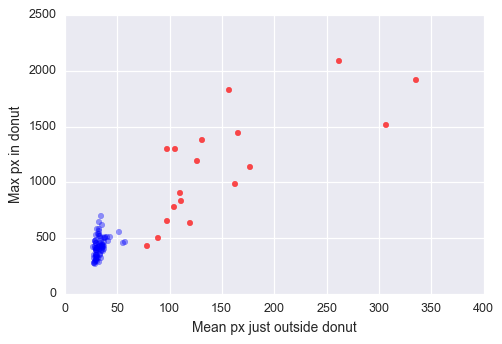

In [275]:
scatter(vecmeans[np.where(labels2==0)], vecmax[np.where(labels2==0)], 
        color='blue', alpha=0.4)
scatter(vecmeans[np.where(labels2==1)], vecmax[np.where(labels2==1)], 
        color='red', alpha=0.7)
xlabel('Mean px just outside donut')
ylabel('Max px in donut')

In [276]:
X_2d = np.array([vecmeans, vecmax]).T
print X.shape, X_2d.shape # from 10000(250000 on a 500x500) we go to 2

(100, 10000) (100, 2)


In [160]:
kneighb2 = KNeighborsClassifier(n_neighbors=2,weights='uniform',algorithm='brute', 
                                leaf_size=10, p=2, metric='minkowski')

%time cc_scores6 = cross_val_score(kneighb2, X_2d, labels2, cv=cv)
print cc_scores6
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores6.mean(), 
                                               cc_scores6.std()*2)

CPU times: user 12.4 ms, sys: 1.51 ms, total: 13.9 ms
Wall time: 13.7 ms
[ 0.96666667  1.          1.          0.96666667  0.93333333  0.9         1.
  0.96666667  0.96666667  0.9       ]
Accuracy: 0.96 (+/- 0.07)


In [161]:
%time cc_scores = cross_val_score(kneighb, X, labels2, cv=cv)
print cc_scores
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores.mean(), 
                                               cc_scores.std()*2)

CPU times: user 383 ms, sys: 20.7 ms, total: 404 ms
Wall time: 232 ms
[ 1.          1.          1.          0.96666667  0.93333333  0.96666667
  1.          0.96666667  1.          0.93333333]
Accuracy: 0.98 (+/- 0.05)


Drastical reduction of computation time, e.g. for KNN. Just slightly decreasing the average of the scores. 

In [162]:
%time cc_scores7 = cross_val_score(dectree, X_2d, labels2, cv=cv)
print cc_scores7
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores7.mean(), 
                                               cc_scores7.std() * 2)

CPU times: user 8.89 ms, sys: 2.56 ms, total: 11.4 ms
Wall time: 8.96 ms
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Accuracy: 1.00 (+/- 0.00)


In [163]:
%time cc_scores3 = cross_val_score(dectree, X, labels2, cv=cv)
print cc_scores3
print "Accuracy: {:0.2f} (+/- {:0.2f})".format(cc_scores3.mean(), cc_scores3.std() * 2)

CPU times: user 731 ms, sys: 20.4 ms, total: 752 ms
Wall time: 757 ms
[ 1.          0.93333333  1.          0.96666667  1.          1.
  0.93333333  0.96666667  0.93333333  0.86666667]
Accuracy: 0.96 (+/- 0.08)


Drastical reduction of computation time also for DecisionTrees. Increased the average of the scores. 

##### Decision boundaries

In [277]:
def plot_decision_boundaries(X_train, y_train):
    kneighb = KNeighborsClassifier(n_neighbors=3,weights='distance',
                                   algorithm='brute', metric='euclidean')
    kneighb.fit(X_train, y_train)

    dectree = DecisionTreeClassifier(criterion='gini', splitter='best', 
                                     max_depth=2, min_samples_split=2, 
                                     min_samples_leaf=1, max_features=None, 
                                     random_state=None)
    dectree.fit(X_train, y_train)

    lda = LDA()
    lda.fit(X_train, y_train)

    rndforest = RandomForestClassifier(n_estimators=10, criterion='gini', 
                                       max_depth=2, min_samples_split=2, 
                                       min_samples_leaf=1, max_features='auto', 
                                       max_leaf_nodes=None, bootstrap=True, 
                                       oob_score=False, n_jobs=1, random_state=None)
    rndforest.fit(X_train, y_train)

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    logr = LogisticRegression(penalty='l2', C=1)
    logr.fit(X_train, y_train)
    
    h = 0.5  # step size in the mesh

    # create a mesh to plot in
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # title for the plots
    titles = ['KNN',
              'DecisionTree',
              'LDA',
              'RandomForest',
              'GNB',
              'Logistic regression']

    figure(figsize=(13.5,9))
    for i, clf in enumerate((kneighb, dectree, lda, rndforest, gnb, logr)):
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        subplot(2, 3, i + 1)
        subplots_adjust(wspace=0.3, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

        # Plot also the training points
        scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.8)
        xlabel('Mean px just outside donut')
        ylabel('Max px in donut')
        overs1=10
        overs2=50
        xlim(xx.min()-overs1, xx.max()+overs1)
        ylim(yy.min()-overs2, yy.max()+overs2)
        title(titles[i])

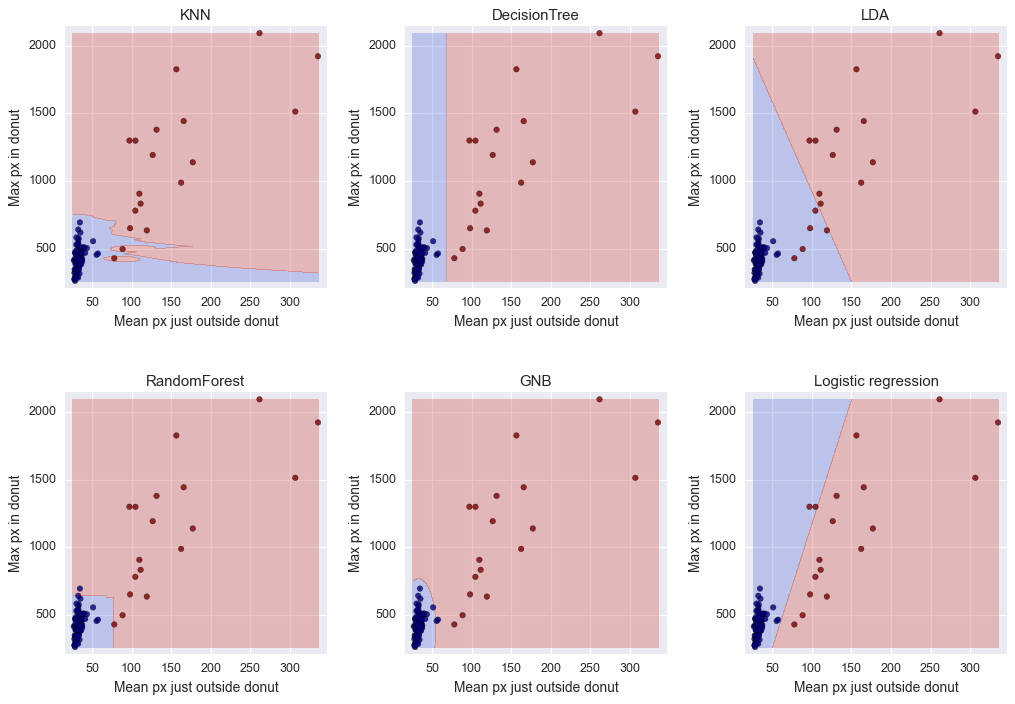

In [281]:
plot_decision_boundaries(X_2d, labels2)

In [166]:
bigann_2_6 = vortex.get_annulus_cube(cubebig, inner_radius=2, width=4, 
                                  output_values=True)
bigann_8_18 = vortex.get_annulus_cube(cubebig, inner_radius=8, width=10, 
                                  output_values=True)

In [167]:
bigvecmeans = bigann_8_18.mean(axis=1)
bigvecmax = bigann_2_6.max(axis=1)

In [168]:
bigX_2d = np.array([bigvecmeans, bigvecmax]).T
print bigX_2d.shape 

(15267, 2)


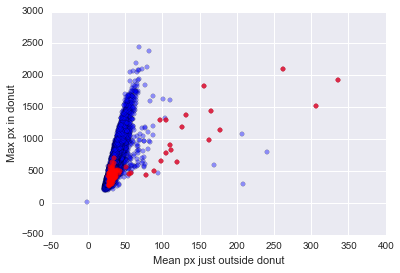

In [169]:
scatter(bigvecmeans, bigvecmax, alpha=0.4)
scatter(vecmeans, vecmax, color='red', alpha=0.7)
xlabel('Mean px just outside donut')
ylabel('Max px in donut')

Not the same behaviour in the big cube, the max pixel in the donut changes in a wider range along the cube. The clusters seeen in the 100x2 matrix are not that clear anymore. It might work well to train on this reduced data but anyway the classifiers are really fast.

### Training on 100 frames classifiers and predicting on bigcube

We'll train on the labeled data, and see how the prediction works on the big cube. We don't have any labels for the big cube, we'll explore the px stats.

In [282]:
X_big.shape

(15267, 10000)

In [283]:
# cube_sel30 = vortex.cube_crop_frames(cube_sel, 40)
# X_labeled = vortex.prepare_matrix(cube_sel30)
X_labeled = vortex.prepare_matrix(cube_sel)
X_labeled.shape

Done creating and centering the matrix


(100, 10000)

In [1282]:
mean = vortex.cube_stats_annulus(cube_X_big[np.where(bigpred_knn==0)], 
                                 inner_radius=8, size=10)
mean.max(), np.where(mean == mean.max())
#ds9(cube_X_big[np.where(bigpred_knn==0)])

Done calculating stats in annulus


Done calculating stats in annulus


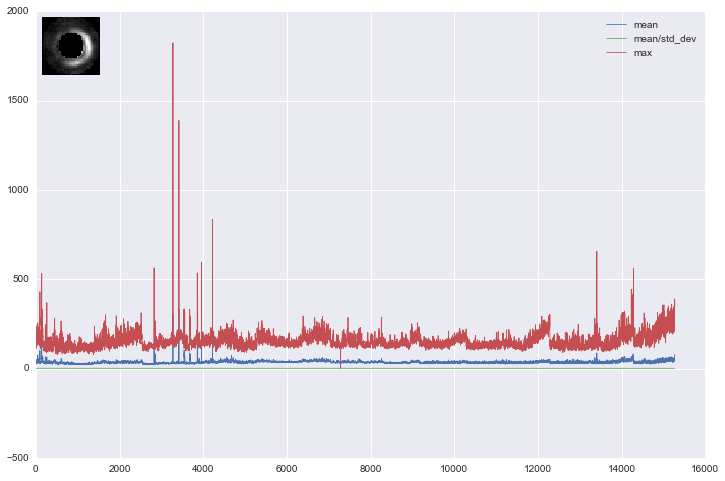

In [172]:
_ = vortex.cube_stats_annulus(cube_X_big, inner_radius=8, size=10, plot=True)

In [1299]:
KNeighborsClassifier?

CPU times: user 2.21 ms, sys: 668 µs, total: 2.88 ms
Wall time: 2.1 ms
CPU times: user 3.4 s, sys: 440 ms, total: 3.84 s
Wall time: 2.15 s

# of bad frames: 599
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


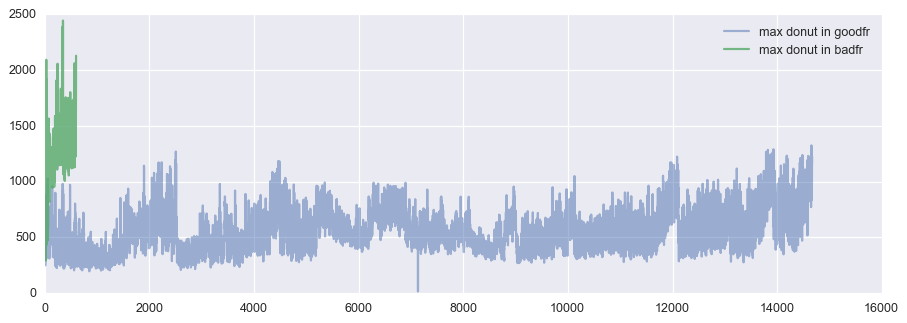

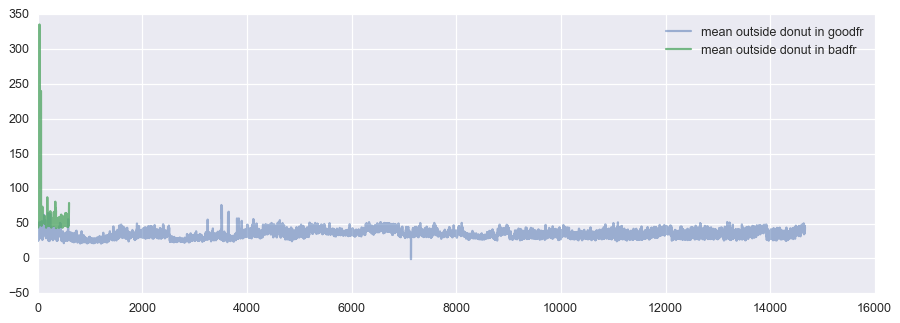

In [285]:
# mahalanobis distance takes forever, cosine doesn't improve
# chebyshev gives very interesting results, 4 times more detections but captures
# the bright frames (max in donut)
kneighb = KNeighborsClassifier(n_neighbors=3, weights='distance',
                               algorithm='brute', metric='euclidean')
%time kneighb.fit(X_labeled, labels2)
%time bigpred_knn = kneighb.predict(X_big)

print '\n# of bad frames:', (bigpred_knn==1).sum()

plot_compare_max_mean(bigpred_knn)

In [262]:
RandomForestClassifier?

CPU times: user 946 ms, sys: 15.8 ms, total: 962 ms
Wall time: 962 ms
CPU times: user 1.26 s, sys: 247 ms, total: 1.51 s
Wall time: 1.53 s

# of bad frames: 48
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


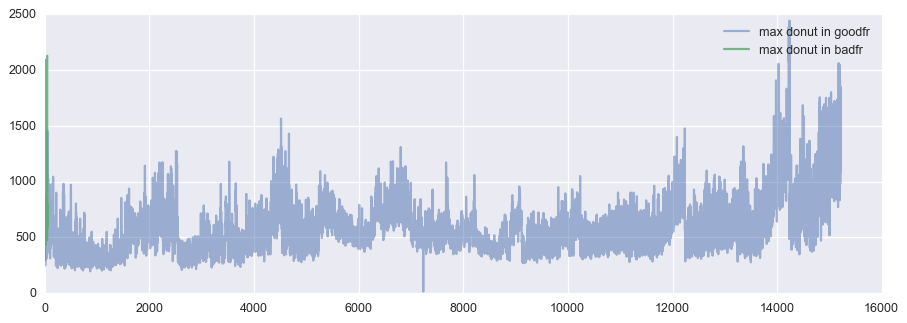

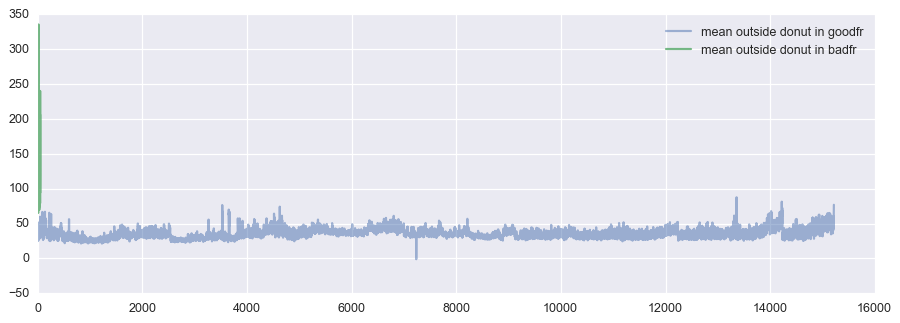

In [287]:
# Will differ from run to run (0 seed)
rndforest = RandomForestClassifier(n_estimators=1000, criterion='gini', 
                                   max_depth=100, min_samples_split=10, 
                                   min_samples_leaf=1, max_features='auto', 
                                   max_leaf_nodes=None, bootstrap=True, 
                                   oob_score=False, n_jobs=1, random_state=0)
%time rndforest.fit(X_labeled, labels2)
%time bigpred_rndf = rndforest.predict(X_big)

print '\n# of bad frames:', (bigpred_rndf==1).sum()

plot_compare_max_mean(bigpred_rndf)

In [253]:
ds9(cube_X_big[np.where(bigpred_rndf==0)],cube_X_big[np.where(bigpred_rndf==1)])

In [272]:
DecisionTreeClassifier?

CPU times: user 84.2 ms, sys: 1.03 ms, total: 85.2 ms
Wall time: 84.6 ms
CPU times: user 445 ms, sys: 217 ms, total: 663 ms
Wall time: 666 ms

# of bad frames: 422
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


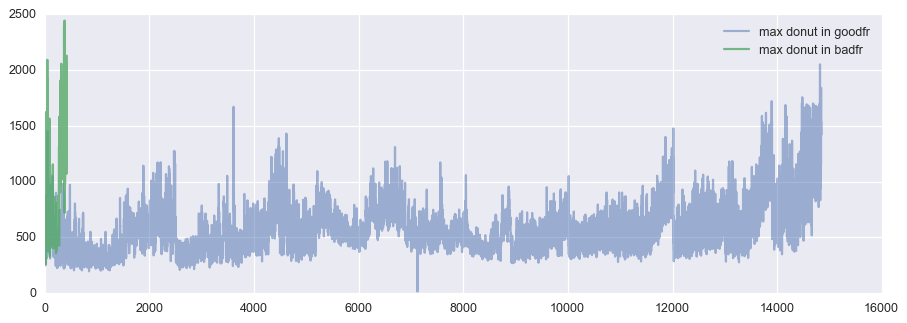

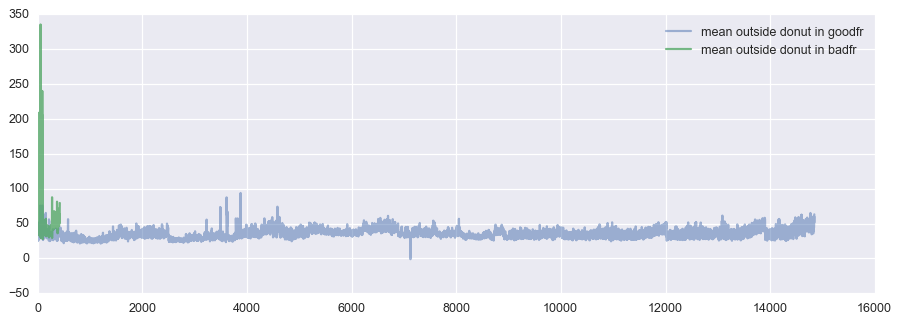

In [288]:
# criterion='entropy' will be much more agressive with the bfr detection
# Decision trees suffer from large variance, I'll leave one realization (0 seed)
dectree = DecisionTreeClassifier(criterion='gini', splitter='best', 
                                 max_depth=2, min_samples_split=2, 
                                 min_samples_leaf=1, max_features=None, 
                                 random_state=0)
%time dectree.fit(X_labeled, labels2)
%time bigpred_dectr = dectree.predict(X_big)

print '\n# of bad frames:', (bigpred_dectr==1).sum()

plot_compare_max_mean(bigpred_dectr)

In [273]:
LDA?

CPU times: user 425 ms, sys: 29.7 ms, total: 454 ms
Wall time: 290 ms
CPU times: user 1.16 s, sys: 476 ms, total: 1.63 s
Wall time: 1.4 s
24
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


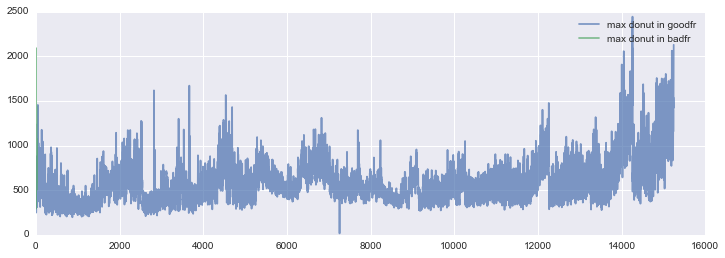

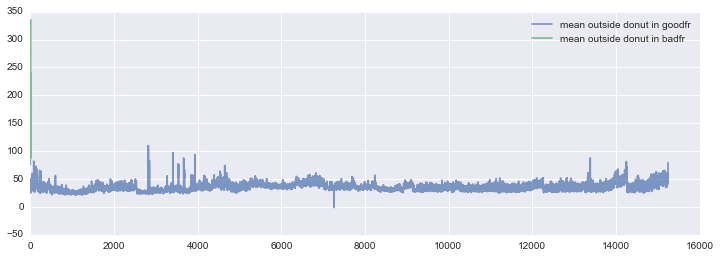

In [179]:
lda = LDA()
%time lda.fit(X_labeled, labels2)
%time bigpred_lda = lda.predict(X_big)

print (bigpred_lda==1).sum()

plot_compare_max_mean(bigpred_lda)

In [269]:
LogisticRegression?

CPU times: user 366 ms, sys: 23 ms, total: 389 ms
Wall time: 248 ms
CPU times: user 940 ms, sys: 473 ms, total: 1.41 s
Wall time: 1.22 s
74
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


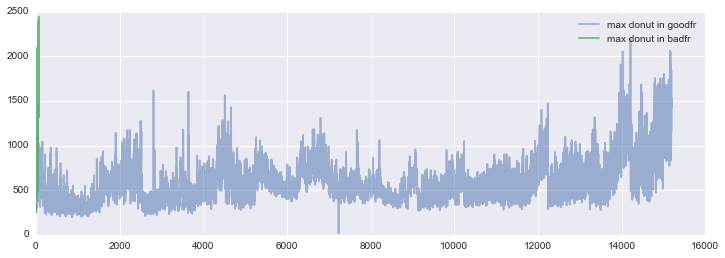

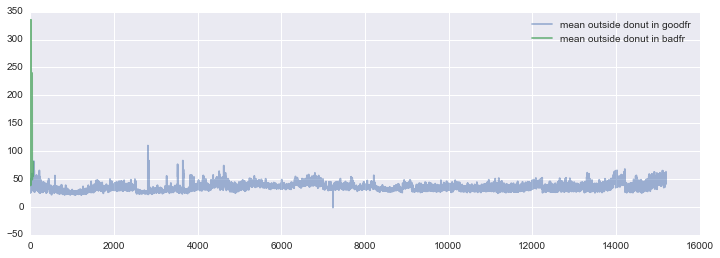

In [270]:
logr = LogisticRegression(penalty='l2', C=1)
%time logr.fit(X_labeled, labels2)
%time bigpred_logr = logr.predict(X_big)

print (bigpred_logr==1).sum()

plot_compare_max_mean(bigpred_logr)

In [292]:
GaussianNB?

CPU times: user 16.5 ms, sys: 4.54 ms, total: 21.1 ms
Wall time: 18.6 ms
CPU times: user 3.21 s, sys: 2.66 s, total: 5.87 s
Wall time: 6.08 s
371
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus
Done calculating stats in annulus


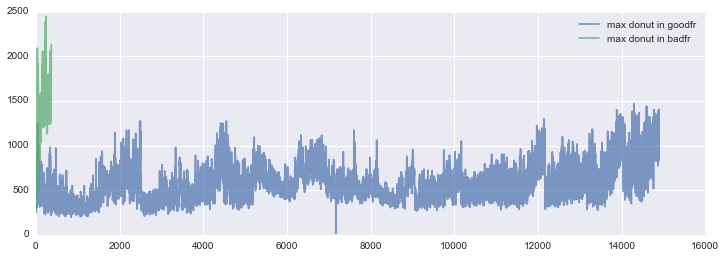

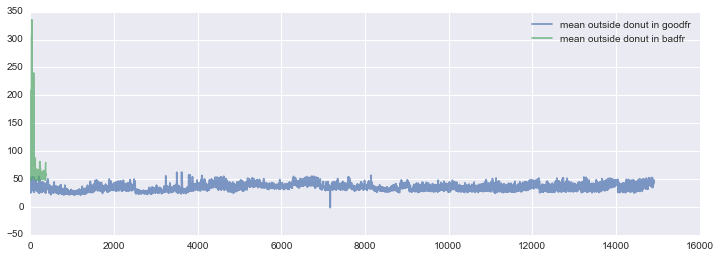

In [182]:
gnb = GaussianNB()
%time gnb.fit(X_labeled, labels2)
%time bigpred_gnb = gnb.predict(X_big)

print (bigpred_gnb==1).sum()

plot_compare_max_mean(bigpred_gnb)

In [249]:
ds9(cube_X_big[np.where(bigpred_gnb==0)],cube_X_big[np.where(bigpred_gnb==1)])

In [295]:
print (bigpred_knn==1).sum()
print (bigpred_rndf==1).sum()
print (bigpred_dectr==1).sum()
print (bigpred_lda==1).sum()
print (bigpred_logr==1).sum()
print (bigpred_gnb==1).sum()

599
48
422
24
74
371


##### General conclusions

- 3 ways: 
    - heuristics (domain knowledge -> thresholding data stats or some data based criteria), 
    - clustering (out of the box partitioning of the data based on distances), 
    - classifier (requires training data, labeling)
- The heuristics work well under some assumptions on the data. They are very fast. We can fine tune the threshold (given that our criterion is good). Hard to evaluate from other perspective than the same criterion, requieres inspecting many frames,
- The classifier training is a tempting option but:
    - requires input from the user. Also, creating the training data is critical: sampling the whole dataset, and having enough examples of both classes (100 frames?). Learning a reliable model usually requires plenty of labeled data,
    - there is no magic allaround best classifier, cross-correlation for tuning the hyperparameters gives us a sense of an algorithm performance, but the performance on real unseen data always differs. This is the bias-variance tradeoff, central problem in supervised learning. Ideally, one wants to choose a model that both accurately captures the regularities in its training data, but also generalizes well to unseen data. Unfortunately, it is typically impossible to do both simultaneously.
- The classifiers work well, very fast all of them (training/prediction):
    - The KNN outstands the rest (probablly they need more hyperparameters tweaking) for it's performance on the training/test data and the real cube predictions and also for its interpretability. 
    - The GNB algorithm is aggresive and effective at the cost of sacrificing some good frames.
- The clustering seems promising. No labeling needed. But: 
    - the combination of appropiate metric and clustering method might be data or size related. No cross-validation here.
- The 3 approaches can be combined. A safer choice is a two stages run. The pxstats gives a good plot for a second detection of bad frames.
- Optimal solution would be some semi-suppervised approach (some labeled data + exploiting the structure of the unlabeled data):
    - Self-training,
    - Multi view learning,
    - Cluster and label,
    - ... this is also an active area. The choice is very data dependant.

##### Paper

- TPR FPR can be used (and probably ROC curves) if it's stated that the trials are done with only fake companions injections -> biased classification, messed up priors
- use a different space for the plots, as in Lawson for example

- try cutting the betapic cube, less frames, less rotations, how decreases the SNR. Can be improved with LRPS? That would be a nice point to make, less observation time per detection
- clear focus of the paper, point like source detection and hability to decrease the noise
- come up with a different detection metric, SNR not suitable anymore (?)
- trials sampling the fake comp flux, detecting the brightest point in the frame

##### Task

make function for training a classifier, one for the clustering. 
- classifier function: recieves a whole cube (bad and good frames) training set with label as parameters. This function will train a classifier and crossvalidate, returning the new labels (bad or good frames).